# Classification

###### COMP4670/8600 - Statistical Machine Learning - Tutorial

In this lab we will build, train, and test a logistic regression classifier.

### Assumed knowledge:

- Optimisation in Python (lab)
- Regression (lab)
- Binary classification with logistic regression (lectures)

### After this lab, you should be comfortable with:

- Implementing logistic regression
- Practical binary classification problems

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

%matplotlib inline

## The data set

We will be working with the census-income dataset, which shows income levels for people in the 1994 US Census. We will predict whether a person has $\leq \$50000$ or $> \$50000$ income per year.

The data are included with this notebook as `04-dataset.tsv`, a textfile where in each row of data, the individual entries are delimited by tab characters. Download the data from the [course website](https://machlearn.gitlab.io/sml2020/tutorials/04-dataset.tsv)
Load the data into a NumPy array called `data` using `numpy.genfromtxt`:

```python
    numpy.genfromtxt(filename)
```

The column names are given in the variable `columns` below.
The `income` column are the targets, and the other columns will form our data used to try and guess the `income`

In [2]:
columns = ['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']

In [3]:
data_raw = np.genfromtxt("04-dataset.tsv")

## Recap - Binary classification

The idea behind this lab is that for each person, we want to
try and predict if their income is above the threshold of $\$50,000$ or not,
based on a series of other data about their person: `age, education,...`.

As per usual, for the $n^\text{th}$ row, the first entry is the target $t_n$, and the rest
forms the data vector $\mathbf{x}_n$.

We have two classes, $C_1$ representing the class of $ <\$ 50,000$, which corresponds to
a target of $t_n = 0$, and $C_2$, representing the class of $ >\$50,000$, corresponding to
a target of $t_n = 1$. Our objective is to learn a discriminative function $f_{\mathbf{w}}(\mathbf{x})$,
parametrised by a weight vector $\mathbf{w}$ that
predicts which income class the person is in, based on the data given.

We assume that each piece of information $(t_n, \mathbf{x}_n)$ is i.i.d, and
that there is some hidden probability distribution from which these target/data points are drawn.
We will construct a likelihood function that indicates "What is the likelihood of this particular
weight vector $\mathbf{w}$ having generated the observed training data $\left\{(t_n, \mathbf{x}_n)\right\}_{n=1}^N$".

## Recap - Feature map, basis function

Now some classes are not linearly seperable (we cannot draw a line such that all of one class is on one side,
and all of the other class is on the other side). But by applying many fixed non-linear 
transformations to the inputs $\mathbf{x}_n$ first, for some suitable choice
of transformation $\phi$ the result will usually be linearly separable
(See week 3, pg 342 of the lecture slides).

We let
$$
\mathbf{\phi}_n := \phi(\mathbf{x}_n)
$$

and work in this feature space rather than the input space.
For the case of two classes, we could guess that the target is a linear combination of the features,
$$
\hat{t}_n = \mathbf{w}^T \mathbf{\phi}_n
$$
but $\mathbf{w}^T \mathbf{\phi}_n$ is a real number, and we want $\hat{t}_n \in \{0,1\}$.
We could threshold the result,
$$
\hat{t}_n =
\begin{cases}
1 & \mathbf{w}^T \mathbf{\phi}_n \geq 0 \\
0 & \mathbf{w}^T \mathbf{\phi}_n < 0
\end{cases}
$$
but the discontinuity makes it impossible to define a sensible gradient. 

## Recap - Logistic Regression

(We assume that the classes are already linearly seperable, and use our input space as our feature space.
We also assume the data is i.i.d).

Instead of using a hard threshold like above, in logistic regression
we can use the sigmoid function $\sigma(a)$
$$
\sigma(a) := \frac{1}{1 + e^{-a}}
$$
which has the intended effect of "squishing" the real line to the interval $[0,1]$.
This gives a smooth version of the threshold function above, that we can differentiate.
The numbers it returns can be interpreted as a probability of the estimated target $\hat{t}$ belonging
to a class $C_i$ given the element $\phi$ of feature space. In the case of two classes, we define

\begin{align}
p(C_1 | \phi ) &:= \sigma (\mathbf{w}^T \phi_n) = y_n \\
p(C_2 | \phi ) &:= 1 - p(C_1 | \phi_n)= 1- y_n
\end{align}


The likelihood function $p(\mathbf{t} | \mathbf{w}, \mathbf{x})$ is what we want to maximise as a function
of $\mathbf{w}$. Since $\mathbf{x}$ is fixed, we usually write the likelihood function as $p(\mathbf{t} | \mathbf{w})$.

$$
\begin{align}
p(\mathbf{t} | \mathbf{w})
&= \prod_{n=1}^N p(t_n | \mathbf{w}) \\
&= \prod_{n=1}^N 
\begin{cases}
p(C_1 | \phi_n) & t_n = 1 \\
p(C_2 | \phi_n) & t_n = 0
\end{cases}
\end{align}
$$
Note that
$$
\begin{cases}
 y_n & t_n = 1 \\
1 - y_n & t_n = 0
\end{cases}
= y_n^{t_n} (1-y_n)^{1-t_n}
$$
as if $t_n = 1$, then $y_n^1 (1-y_n)^{1-1} = y_n$ and if $t_n = 0$ then $y_n^0 (1-y_n)^{1-0} = 1-y_n$.
This is why we use the strange encoding of $t_n=0$ corresponds to $C_2$ and $t_n=1$ corresponds to $C_1$.
Hence, our likelihood function is 
$$
p(\mathbf{t} | \mathbf{w}) = \prod_{n=1}^N y_n^{t_n} (1-y_n)^{1-t_n}, \quad y_n = \sigma(\mathbf{w}^T \phi_n)
$$
This function is quite unpleasant to try and differentiate, but we note that $p(\mathbf{t} | \mathbf{w})$
is maximised when $\log p(\mathbf{t} | \mathbf{w})$ is maximised.
\begin{align}
\log p(\mathbf{t} | \mathbf{w}) 
&= \log \prod_{n=1}^N y_n^{t_n} (1-y_n)^{1-t_n} \\
&= \sum_{n=1}^N \log \left( y_n^{t_n} (1-y_n)^{1-t_n} \right) \\
&= \sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)
\end{align}
Which is maximised when $- \log p(\mathbf{t} | \mathbf{w})$ is minimised, giving us our error function.
$$
E(\mathbf{w}) := - \sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)
$$
We can then take the derivative of this, which gives us
$$
\nabla_\mathbf{w} E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n) \phi_n
$$

(Note: We also usually divide the error by the number of data points, to obtain the average error. The error
shouldn't get 10 times as large just because there is more data avaliable, so we should divide by the
number of error points to reflect that.)

## Q1. Derivative of binary cross entropy
Take the derivative of $E(\mathbf{w})$, and show that it is equal to the above. Note that the derivative doesn't have any sigmoid functions. (Hint: Use the identity $\sigma'(a) = \sigma(a) \left( 1- \sigma(a) \right)$ to simplify).

### solution:
Given in the lecture notes

## Q2. $L_2$ regularisation, Gaussian prior

Now we consider an isotropic guassian prior for $\mathbf{w}$ (i.e. $w \sim \mathcal{N}(\mathbf{0},\alpha^{-1}I) $). Use the likelihood we derived above and the Gaussian prior, show that the error function could be writen as $$ E(\mathbf{w}) = - (\sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)) + \frac{\lambda}{2}\Vert \mathbf{w} \Vert_2^2$$ for some $\lambda$. Write out the relation between $\lambda$ and $\alpha$.

Hint: Derive the negative logarithm of posterior $p(\mathbf{w}|\mathbf{t})$ and discard the constants.

### solution:

By bayes formula, we know that $p(\mathbf{w}|t) \propto p(t|\mathbf{w})p(\mathbf{w})$. Hence, the error function could be written as
$$
\begin{align}
E(\mathbf{w}) &= -\log p(\mathbf{t}|\mathbf{w}) - \log p(\mathbf{w}) \\
&=  - \left(\sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)\right) + \frac{\alpha}{2}\Vert \mathbf{w} \Vert_2^2 + const.
\end{align}
$$
And $\lambda = \alpha$.

## Q3. Derivative of binary cross entropy with regularisation
Take the derivative of $E(\mathbf{w})$ again, accounting for the added regularisation term.

### solution:
$$\sum_{n=1}^N (y_n - t_n) \phi_n + \alpha \mathbf{w}$$

## Q4. Classification with logistic regression

Implement binary classification using logistic regression and $L_2$ regularisation. Make sure you write good quality code with comments and docstrings where appropriate. In this question, we use the mean error function defined above.

$$ E(\mathbf{w}) = \frac{1}{N}\left\{-\left(\sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n)\right)\right) + \frac{\lambda}{2}\Vert \mathbf{w} \Vert_2^2\right\}$$

To optimise your cost function, we will implement a stochastic gradient descent algorithm by hand. We first recall that, in (full-batch) gradient descent, the iteration formula is given by $$ \mathbf{w}_{k+1} = \mathbf{w}_k - \eta\nabla_{\mathbf{w}}E(\mathbf{w}_k),$$ where $\eta$ is the learning rate. For stochatsic gradient descent, instead of using the full dataset in each iteration, we will divide the dataset into several mini-batches and use the gradient with respect to one mini-batch to update the parameter in each iteration. Specificly, we first write our regulariser into the sum, 
$$ E(\mathbf{w}) = \frac{1}{N}\sum_{n=1}^N \left\{ -\left(t_n \log y_n +  (1-t_n) \log (1-y_n)\right) + \frac{\lambda}{2N}\Vert \mathbf{w} \Vert_2^2 \right\}.$$ Then, for a minibatch $\mathcal{B}_i$ (suppose $\mathcal{B}_i$ is a set of indices), the stochastic gradient $g_{\mathcal{B}_i}$ could be defined as 
$$ g_{\mathcal{B}_i}(\mathbf{w}_k) = \frac{1}{N_{\mathcal{B}_i}}\nabla_\mathbf{w}\left\{\sum_{n\in\mathcal{B}_i} \left\{ -\left(t_n \log y_n +  (1-t_n) \log (1-y_n)\right) + \frac{\lambda}{2N}\Vert \mathbf{w} \Vert_2^2 \right\}\right\}\Bigg\vert_{\mathbf{w} = \mathbf{w}_k}.$$ In each step, the updation formula is given by $$ \mathbf{w}_{k+1} = \mathbf{w}_{k} - \eta g_{\mathcal{B}_i}(\mathbf{w}_k).$$ Note that, for each iteration, we can choose a mini-batch in turn.


By above equations, implement five functions:

- `cost(w, X, t, a, N)`, which calculates the value of the cost function in a mini-batch,
- `grad(w, X, t, a, N)`, which calculates the (stochastic) gradient of the cost function in a mini-batch,
- `create_mini_batches(X_train, t_train, num_batches)`, which creates a list of mini-batch,
- `train(X_train, t_train, a, learning_rate, num_iterations, num_batches)`, which returns the maximum likelihood weight vector using stochastic gradient desecent, and
- `predict(w, X)`, which returns predicted class probabilities,

where 
* $\mathbf{w}$ is a weight vector, 
* $X$ is a matrix of examples, 
* $t$ is a vector of labels/targets, 
* $a$ is the regularisation weight. 

(We would use $\lambda$ for the regularisation term, but `a` is easier to type than `lambda`, and
`lambda` is a reserved keyword in python, for lambda functions).

See below for expected usage.

We add an extra column of ones to represent the bias term.

## Note

* You should use 80% of the data as your training set, and 20% of the data as your test set.
* You also may want to normalise the data before hand. If the magnitude of $\mathbf{w}^T \phi_n$
is very large, the gradient of $\sigma(\mathbf{w}^T \phi_n)$ will be very near zero, which can
cause convergence issues during numerical minimisation. If each element in a particular column is
multiplied by a scalar (say, all elements of the `age` column) then the result is essentially the same
as stretching the space in which the data lives. The model will also be proportionally stretched,
but will not fundamentally change the behaviour. So by normalising each column, we can avoid
issues related to numerical convergence.

In [4]:
assert data_raw.shape[1] == len(columns)
data = np.concatenate([data_raw, np.ones((data_raw.shape[0], 1))], axis=1)  # add a column of ones
data.shape

(32561, 9)

### Q4a. Define the loss and gradient
Implement sigmoid function, binary cross entropy and the gradient of the error function as defined above. Note that the `cost` and `grad` function could work both in the full batch or mini-batches (by tunning the parameter `N`).

In [5]:
def sigmoid(a):
    
    return 1 / (1 + np.exp(-a))

def cost(w, X, t, a, N): # N is the total sample size
    y = predict(w, X)
    l2 = (w**2).sum() * a/2
    likelihood = t @ np.log(y) + (1 - t) @ np.log(1 - y)
    cost = (l2 - likelihood)/N
    return cost

def stochastic_grad(w, X, t, a, N, N_batch): # N is the total sample size
    y = predict(w, X)
    return ((X * (y.reshape(t.shape) - t).reshape((X.shape[0],1))).sum(axis=0))/N_batch + (a/N) * w

def batch_grad(w, X, t, a, N): # N is the total sample size
    y = predict(w, X)
    return ((X * (y - t)[:, None]).sum(axis=0) + a * w )/N

In [6]:
# Code for splitting data into train and test with ratio 80/20

N = np.shape(data)[0]
num_train = int(0.8*N)
t_train = data[:num_train,0]
t_test = data[num_train:, 0]
#32561
norm_data = data[:, 1:] / data[:, 1:].sum(axis=0, keepdims=True)
X_train = norm_data[:num_train, :]
X_test = norm_data[num_train:, :]
assert X_test.shape[1] == len(columns)
x_columns = columns[1:] + ['bias']

### Q4b. Divide mini-batches
Given the training set and the number of minibatches we want, implememt the function `create_mini_batches` which will return a list of tuples such that each tuple represents a mini-batch which contains features and corresponding targets. (i.e. the output should be $[(X_1,t_1), (X_2,t_2), \ldots, (X_{num\_batches},t_{num\_batches})])$

Hint: Use `np.random.shuffle()` to shuffle the dataset first. Make sure training data are spread as evenly as you can.

In [7]:
def create_mini_batches(X_train, t_train, num_batches):
    mini_batches = []
    data = np.hstack((X_train, t_train.reshape((X_train.shape[0],1))))
    np.random.shuffle(data)
    batch_size = data.shape[0] // num_batches
  
    for i in range(num_batches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

### Q4c. Train the model
Implement the function `train(mini_batches, a, learning_rate, num_iterations)` which returns the maximum likelihood weight vector using stochastic gradient desecent. You can tune your `learning_rate` and `num_iterations` to attain better performance. 

Hint: You can try to plot the loss-iteration curve to make sure your algorithm converge properly.

In [8]:
# Code for training the model and making predictions

def train(X_train, t_train, a, learning_rate, num_iterations, num_batches):  # a is regularisation parameter
    
    # Keep track of loss value
    loss_his = []
    
    # Create mini-batches
    mini_batches = create_mini_batches(X_train, t_train, num_batches)
    
    # Initialise parameter
    w = np.random.randn(X_train.shape[1])
    
    # Train
    for i in range(num_iterations):
        batch_num = np.mod(i, num_batches)
        s_grad = stochastic_grad(w, mini_batches[batch_num][0], mini_batches[batch_num][1],a, 32561,mini_batches[batch_num][0].shape[0])
        w -= learning_rate * s_grad
        loss = cost(w, X_train, t_train, a, X_train.shape[0])
        loss_his.append(loss)
        
        # print the loss per 1000 iters
        if np.mod(i,1000) == 0:
            print("*"*40)
            print("The loss in iteration ",i, " is ",loss)
    
    
    plt.xlabel("# iterations")
    plt.ylabel("loss")
    plt.plot(loss_his)
    
    return w

def predict(w, X):
    return sigmoid(X @ w)

### Q4d. Make predictions
Use the code above to train your model by calculating the weights for your model and making predictions for the test data.

Hint: Compare your training loss with the one using `opt.fmin_bfgs`, your resulting loss should be better or roughly equal to the one computed by inbuilt functions.
This is not easy to train, please restart and potentially tune the hyperparameters if youre loss diverge or you get a bad generalisation.

****************************************
The loss in iteration  0  is  0.6931370189314874
****************************************
The loss in iteration  1000  is  0.6931334911959091
****************************************
The loss in iteration  2000  is  0.6931302023355682
****************************************
The loss in iteration  3000  is  0.6931271372393168
****************************************
The loss in iteration  4000  is  0.6931242817235441
****************************************
The loss in iteration  5000  is  0.6931216224760548
****************************************
The loss in iteration  6000  is  0.6931191470033191
****************************************
The loss in iteration  7000  is  0.6931168435808911
****************************************
The loss in iteration  8000  is  0.6931147012068094
****************************************
The loss in iteration  9000  is  0.6931127095577978
****************************************
The loss in iteration  10000  is

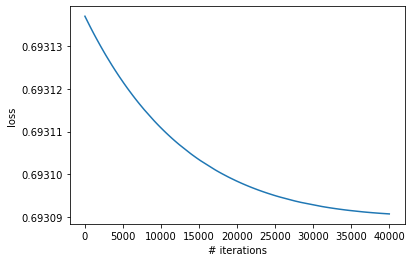

In [9]:
w_train = train(X_train, t_train, 0.1, 10, 40000, 200)  
# TODO：This is not easy to train, please restart and potentially tune the hyperparameters if youre loss diverge or you get a bad generalisation.
print('Your training loss is:')
print(cost(w_train, X_train, t_train, 0.1, X_train.shape[0]))
w_train_bfgs = opt.fmin_bfgs(
        f=cost, fprime=batch_grad, x0=np.random.normal(scale=0.2, size=(X_train.shape[1],)), args=(X_train, t_train, 0.1, X_train.shape[0]), disp=0)
print('The training loss using opt.fmin_bfgs is:')
print(cost(w_train_bfgs, X_train, t_train, 0.1, X_train.shape[0]))
t_test_pred = predict(w_train, X_test)  # TODO
print('The predictions are:')
print(t_test_pred)
print('The trained parameters are:')
print(w_train)

## Q5. Performance measure

There are many ways to compute the performance of a binary classifier. The key concept is the idea of a confusion matrix:

|     &nbsp;         | &nbsp;  | Label | &nbsp;  |
|:-------------:|:--:|:-----:|:--:|
|     &nbsp;         |  &nbsp;  |  0    | 1  |
|**Prediction**| 0  |    TN | FN |
|      &nbsp;        | 1  |    FP | TP |

where
* TP - true positive
* FP - false positive
* FN - false negative
* TN - true negative

Implement three functions:

- `confusion_matrix(y_true, y_pred)`, which returns the confusion matrix as a list of lists given a list of true labels and a list of predicted labels;
- `accuracy(cm)`, which takes a confusion matrix and returns the accuracy; and
- `balanced_accuracy(cm)`, which takes a confusion matrix and returns the balanced accuracy.

The accuracy is defined as $\frac{TP + TN}{n}$, where $n$ is the total number of examples. The balanced accuracy is defined as $\frac{1}{2}\left(\frac{TP}{P} + \frac{TN}{N}\right)$, where $T$ and $N$ are the total number of positive and negative examples respectively.

In [10]:
# solution
def confusion_matrix(t_true, t_pred):
    t_pred = t_pred > 0.5
    t_true = t_true > 0.5
    tp = ((t_true == t_pred) & (t_true)).sum()
    tn = ((t_true == t_pred) & (~t_true)).sum()
    fp = ((t_true != t_pred) & (~t_true)).sum()
    fn = ((t_true != t_pred) & (t_true)).sum()
    return [[tn, fn], [fp, tp]]

def accuracy(cm):
    (TN, FN), (FP, TP) = cm
    return (TN + TP) / (TN + FN + FP + TP)

def balanced_accuracy(cm):
    (TN, FN), (FP, TP) = cm
    return (TN / (TN + FP) + TP / (TP + FN)) / 2

## Accuracy vs balanced accuracy

What is the purpose of balanced accuracy? When might you prefer it to accuracy?

### solution
Balanced accuracy accounts for class imbalance. In the extreme case, you would use it if you have imbalanced classes.
For example, suppose you had some model that you were trying to learn if a patient had cancer based on
MRI scan data, and the prior probability on any one person having cancer is 0.1%.
Out of thousands of training examples, only a handful might actually have cancer. By just making the model always
say "no, this person doesn't have cancer" it's already 99.9% accurate. During training, the model may just 
naturally do this, by overfitting to the cases where cancer was not present.
But the penalty for a false positive 
(the model says you have cancer when you don't) is far less bad than a false negative (the model says you are okay when you do have cancer). So we need our accuracy to be weighted by the number of training examples.

## Putting everything together

Consider the following code which computes the accuracy and balanced accuracy. Discuss the results. (Your accuaray shoud be around `[0.75,0.5]`, you can retrain the model if your accuracy is not satisfying)

In [11]:
cmatrix = confusion_matrix(t_test, t_test_pred)
[accuracy(cmatrix), balanced_accuracy(cmatrix)]

[0.7933364041148472, 0.5941260431508244]

### solution
We get higher accuracy than balanced accuracy. This means that our data are class-imbalanced, and logistic regression may be over-fitting.

## Q6. Looking back at the prediction task

Based on your results, what feature of the dataset is most useful for determining the income level? What feature is least useful? Why?

Hint: take a look at ```w_train```.

('age', -1.579219284110021)
('education', -1.9422940836578835)
('private-work', -2.006245037207752)
('married', -0.5523258314939528)
('capital-gain', 2.9037951894794856)
('capital-loss', -0.021546876511379355)
('hours-per-week', -1.6331986818810098)
('bias', -1.9615194689583941)
capital-gain is the most important feature as it has the highest magnitude of weight


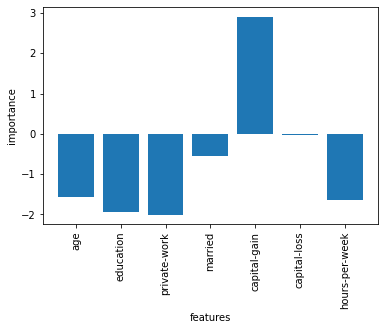

In [12]:
# solution
assert len(w_train) == len(x_columns)
plt.bar(range(len(w_train)-1), w_train[:-1])
plt.ylabel('importance')
plt.xlabel('features')
plt.xticks(range(len(w_train)-1), x_columns[:-1], rotation='vertical');
print('\n'.join(map(str, list(zip(x_columns, w_train)))))

# ignore the last weight (bias):
i_w_abs_max = np.argmax(np.abs(w_train[:-1])) 
# skip the first column, which is for the target
print(x_columns[i_w_abs_max], 'is the most important feature as it has the highest magnitude of weight')
